In [35]:
#Import the necessary libraries
from qiskit import *
from qiskit import BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import numpy as np
import matplotlib.pyplot as plt

In [36]:
# Vectors used to compute the distance 

vectors= [[[10,6,4,8], [10,6,4,7]],
          [[10,6,4,8], [9,6,4,9] ],
          [[10,6,4,8], [9,6,5,7] ],
          [[10,6,4,8], [8,6,4,6] ],
          [[10,6,4,8], [7,6,5,6] ],
          [[10,6,4,8], [7,5,8,6] ],
          [[10,6,4,8], [5,5,8,6] ],
          [[10,6,4,8], [2,5,12,5]],
          [[12,6,4,8], [2,10,14,5]],
          [[12,18,2,16],[2,7,12,5]],
          [[14,18,2,16],[2,5,12,5]],
          [[16,20,2,17],[4,7,12,1]],
          [[16,20,2,18],[4,5,12,1]],
          [[16,20,2,17],[2,4,15,1]],
          [[18,24,2,19],[5,6,18,1]],
          [[18,24,2,19],[5,6,21,1]],
          [[18,24,2,19],[2,3,21,1]],
         ]

vectors_array = np.array(vectors)

In [ ]:
real_distance_list = []
quantum_distance_list = []
shots = 4000
iteration = 0
runs = 20

print(f'Results with an average of {runs} runs and {shots} shots')
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")
for vector in vectors_array:
    A = vector[0]
    B = vector[1]
    
    iteration+=1
    print("Iteration",iteration)
    print("Vectors:")
    print(A)
    print(B)
   
    norm_A = 0 
    norm_B = 0
    Dist = 0
    
    # Compute the classical distance 
    for i in range(len(A)):
        norm_A += A[i]**2
        norm_B += B[i]**2
        Dist += (A[i] - B[i]) ** 2
    
    Dist = np.sqrt(Dist)
    
    A_norm = np.sqrt(norm_A)
    B_norm = np.sqrt(norm_B)
    Z = round((A_norm)**2 + (B_norm)**2)
    #print(Z)
    
    # create phi and psi state with the vector data
    phi = [A_norm/np.sqrt(Z), -B_norm/np.sqrt(Z)]
    psi = []
    for i in range(len(A)):
        psi.append(((A[i]/A_norm) / np.sqrt(2)))
        psi.append(((B[i]/B_norm) / np.sqrt(2)))
        
    # Create circuit 
    q1 = QuantumRegister(1, name = 'q1')
    q2 = QuantumRegister(4, name = 'q2')
    c = ClassicalRegister(1, name = 'c')
    qc = QuantumCircuit(q1,q2,c)

    #States initialization
    qc.initialize(phi, q2[0])
    qc.initialize(psi, q2[1:4])
    
    # The swap test operator
    qc.h(q1[0])
    qc.cswap(q1[0], q2[0], q2[1])
    qc.h(q1[0]) 
    qc.measure(q1,c)
    
    q_distance_list_for_runs = []
    real_distance_list.append(Dist)
    
    for i in range(runs):
        job = execute (qc,Aer.get_backend('qasm_simulator'),shots=shots)
        job_result = job.result()
        counts = job_result.get_counts(qc)
        x = abs(((counts['0']/shots - 0.5)/0.5) * 2 * Z) #.05
        Q_Dist = round(np.sqrt(x),4)
        q_distance_list_for_runs.append(Q_Dist)
    
    quantum_distance_list.append(np.array(q_distance_list_for_runs).mean())
    print("Results:")
    print('Quantum Distance: ', round(np.array(q_distance_list_for_runs).mean(),3))
    print('Euclidean Distance: ',round(Dist,3))
        
    print("---------------------------------------------------------------")

Results with an average of 20 runs and 4000 shots
---------------------------------------------------------------
---------------------------------------------------------------
Iteration 1
Vectors:
[10  6  4  8]
[10  6  4  7]
Results:
Quantum Distance:  2.796
Euclidean Distance:  1.0
---------------------------------------------------------------
Iteration 2
Vectors:
[10  6  4  8]
[9 6 4 9]
Results:
Quantum Distance:  3.297
Euclidean Distance:  1.414
---------------------------------------------------------------
Iteration 3
Vectors:
[10  6  4  8]
[9 6 5 7]
Results:
Quantum Distance:  3.012
Euclidean Distance:  1.732
---------------------------------------------------------------
Iteration 4
Vectors:
[10  6  4  8]
[8 6 4 6]
Results:
Quantum Distance:  3.418
Euclidean Distance:  2.828
---------------------------------------------------------------
Iteration 5
Vectors:
[10  6  4  8]
[7 6 5 6]
Results:
Quantum Distance:  3.267
Euclidean Distance:  3.742
----------------------------------

In [38]:
error_20_run = np.abs(np.array(quantum_distance_list) -  np.array(real_distance_list))
error_20_run

array([1.63123   , 1.20044144, 1.15652419, 0.04362712, 0.24041739,
       0.18070058, 0.12807998, 0.12023988, 0.252285  , 0.19275896,
       0.25203498, 0.25020931, 0.1027302 , 0.09676079, 0.14863371,
       0.2957246 , 0.06282559])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


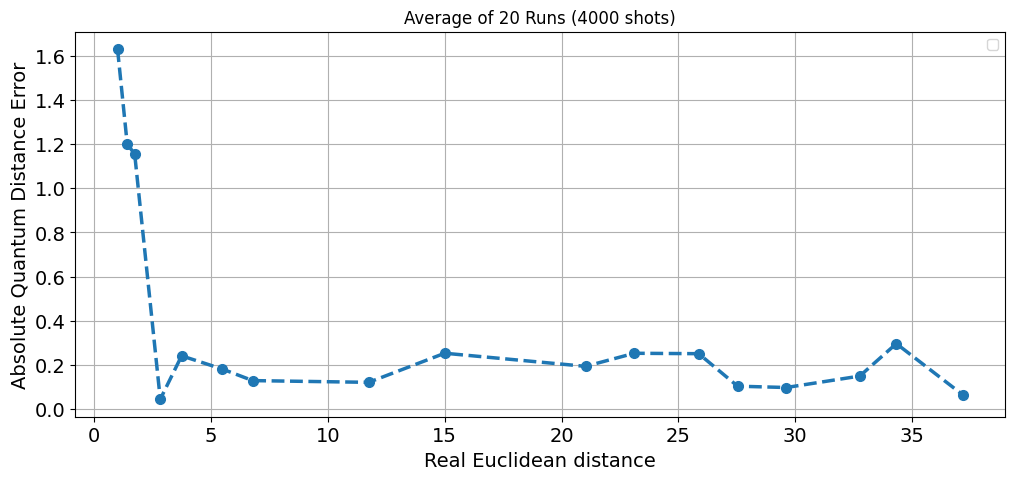

In [40]:
plt.figure(figsize=(12, 5))
plt.plot(np.array(real_distance_list), error_20_run, "o--", linewidth=2.5, markersize=7)
plt.xticks(size=14)
plt.yticks(size=14)
#plt.xticks(np.arange(99,99.999, step=0.1),size=14)
plt.title(r"Average of 20 Runs (4000 shots)")
plt.ylabel('Absolute Quantum Distance Error', size= 14)
plt.xlabel('Real Euclidean distance', size=14)
plt.legend()
plt.grid()
plt.show()
#plt.savefig("Distance_error.png")

# Noise model 

In [10]:
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit.providers.aer import AerSimulator

In [11]:
noise_values = [0.001, 0.0015, 0.002, 0.005, 0.01]

In [28]:
real_distance_list = []
noisy_quantum_distance_list = []
shots = 4000
iteration = 0
runs = 20

print(f'Results with an average of {runs} runs and {shots} shots')
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")
for vector in vectors_array:
    A = vector[0]
    B = vector[1]
    
    iteration+=1
    print("Iteration",iteration)
    print("Vectors:")
    print(A)
    print(B)
   
    norm_A = 0 
    norm_B = 0
    Dist = 0
    
    # Compute the classical distance 
    for i in range(len(A)):
        norm_A += A[i]**2
        norm_B += B[i]**2
        Dist += (A[i] - B[i]) ** 2
    
    Dist = np.sqrt(Dist)
    
    A_norm = np.sqrt(norm_A)
    B_norm = np.sqrt(norm_B)
    Z = round((A_norm)**2 + (B_norm)**2)
    #print(Z)
    
    # create phi and psi state with the vector data
    phi = [A_norm/np.sqrt(Z), -B_norm/np.sqrt(Z)]
    psi = []
    for i in range(len(A)):
        psi.append(((A[i]/A_norm) / np.sqrt(2)))
        psi.append(((B[i]/B_norm) / np.sqrt(2)))
        
    # Create circuit 
    q1 = QuantumRegister(1, name = 'q1')
    q2 = QuantumRegister(4, name = 'q2')
    c = ClassicalRegister(1, name = 'c')
    qc = QuantumCircuit(q1,q2,c)

    #States initialization
    qc.initialize(phi, q2[0])
    qc.initialize(psi, q2[1:4])
    
    # The swap test operator
    qc.h(q1[0])
    qc.cswap(q1[0], q2[0], q2[1])
    qc.h(q1[0]) 
    qc.measure(q1,c)
    
    q_distance_list_for_runs = []
    real_distance_list.append(Dist)
    
    error_1 = depolarizing_error(0.0001, 1)
    error_2 = depolarizing_error(0.01, 2)
    # Add errors to noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['id', 'rz', 'sx', 'x',])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    #print(noise_model)
    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    
    for i in range(runs):
        # Perform a noise simulation
        backend = AerSimulator(noise_model=noise_model,
                       basis_gates=basis_gates)
        transpiled_circuit = transpile(qc, backend)
        #print(transpiled_circuit.draw())
        result = backend.run(transpiled_circuit, shots=shots).result()
        #probs.append(result.get_counts().get("0111")/1024)
        x = abs(((result.get_counts().get("0")/shots - 0.5)/0.5) * 2 * Z) #.05
        Q_Dist = round(np.sqrt(x),4)
        q_distance_list_for_runs.append(Q_Dist)
    
    noisy_quantum_distance_list.append(np.array(q_distance_list_for_runs).mean())
    print("Results:")
    print('Noisy Quantum Distance: ', round(np.array(q_distance_list_for_runs).mean(),3))
    print('Euclidean Distance: ',round(Dist,3))
        
    print("---------------------------------------------------------------")

Results with an average of 20 runs and 4000 shots
---------------------------------------------------------------
---------------------------------------------------------------
Iteration 1
Vectors:
[10  6  4  8]
[10  6  4  7]
Results:
Noisy Quantum Distance:  4.668
Euclidean Distance:  1.0
---------------------------------------------------------------
Iteration 2
Vectors:
[10  6  4  8]
[9 6 4 9]
Results:
Noisy Quantum Distance:  5.164
Euclidean Distance:  1.414
---------------------------------------------------------------
Iteration 3
Vectors:
[10  6  4  8]
[9 6 5 7]
Results:
Noisy Quantum Distance:  5.337
Euclidean Distance:  1.732
---------------------------------------------------------------
Iteration 4
Vectors:
[10  6  4  8]
[8 6 4 6]
Results:
Noisy Quantum Distance:  5.312
Euclidean Distance:  2.828
---------------------------------------------------------------
Iteration 5
Vectors:
[10  6  4  8]
[7 6 5 6]
Results:
Noisy Quantum Distance:  5.511
Euclidean Distance:  3.742
----

In [29]:
noisy_error_20_run = np.abs(np.array(noisy_quantum_distance_list) -  np.array(real_distance_list))
noisy_error_20_run

array([3.66786500e+00, 3.75022644e+00, 3.60513419e+00, 2.48331288e+00,
       1.76911761e+00, 1.48668442e+00, 8.56145017e-01, 1.33487553e-03,
       2.23780000e-01, 2.63318958e-01, 2.88050166e-02, 1.60155687e-01,
       3.82239796e-01, 3.02355790e-01, 3.11818708e-01, 5.96579603e-01,
       6.51390591e-01])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


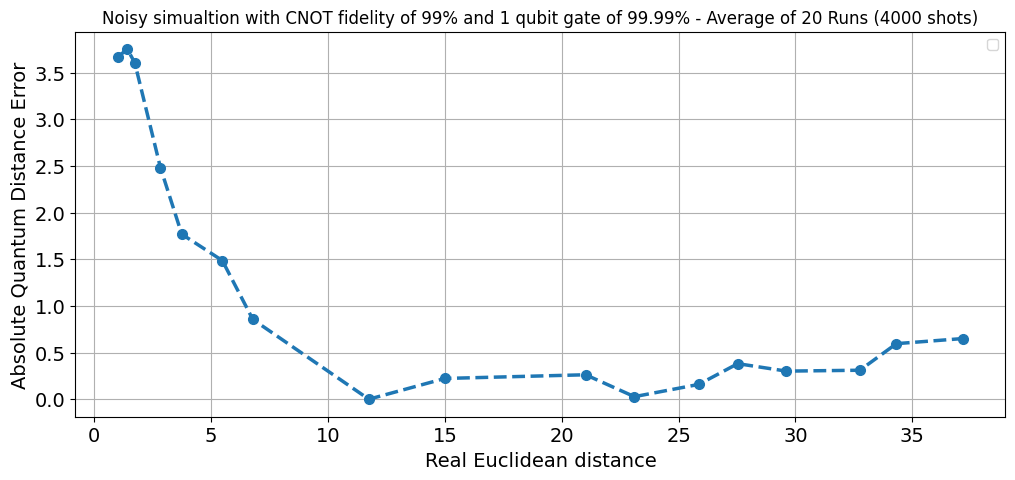

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(np.array(real_distance_list), noisy_error_20_run, "o--", linewidth=2.5, markersize=7)
plt.xticks(size=14)
plt.yticks(size=14)
#plt.xticks(np.arange(99,99.999, step=0.1),size=14)
plt.title(r"Noisy simualtion with CNOT fidelity of 99% and 1 qubit gate of 99.99% - Average of 20 Runs (4000 shots)")
plt.ylabel('Absolute Quantum Distance Error', size= 14)
plt.xlabel('Real Euclidean distance', size=14)
plt.legend()
plt.grid()
plt.show()
#plt.savefig("Distance_error.png")